In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/abohane/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
cost_data = pd.read_csv('data/cost_v1.csv') #
dwell_data = pd.read_csv('data/dwell_time_v1.csv')
mall_data = pd.read_csv('data/mall_v1.csv') #
# mall_traffic_data = pd.read_csv('data/mall_traffic.csv')
people_data = pd.read_csv('data/people_flow_v1.csv')
store_data = pd.read_csv('data/store_v1.csv') #
ref_data = pd.read_csv('data/referenciel_traffic_v1.csv')


total_cost_df = pd.read_csv('data/total_cost_df.csv')

## Store Data Analysis

- There are 5870 unique stores names. We have no information about the actual real life store names, so for example multiple 'Zara' stores in different malls would have different store_names

- There are 85 unique malls
- There are threel levels of store type granularity, branch level 1 (18), branch level 2 (59), branch level 3 (142)

In [3]:
merge_dwell_people = pd.merge(dwell_data, people_data, how='inner', on=['external_mall_id', 'block_id'])

In [4]:
final_vision = pd.merge(merge_dwell_people, ref_data, how='inner', on=['external_mall_id', 'block_id'])

In [5]:
final_vision.head()

,external_mall_id,block_id,average_dwell_time,median_dwell_time,store_visits_monthly_average,store_window_flow_monthly_average,store_visits_daily_average,store_window_flow_daily_average,store_total_visits,store_total_window_flow,days_with_traffic_data,store_id
0,18,11273,249.520051,180.0,9810.25,472952.50,509.62,24568.96,39241,1891810,77,9257.0
1,18,11271,190.005359,120.0,4891.25,362107.00,254.09,18810.75,19565,1448428,77,9443.0
2,17,4319,1325.216860,780.0,1981.23,280719.08,70.37,9970.90,25756,3649348,366,5697.0
3,36,1201,621.422549,240.0,29753.50,751216.75,1226.95,30978.01,119014,3004867,97,7179.0
4,36,1212,217.833860,120.0,6082.50,357884.00,253.44,14911.83,24330,1431536,96,7288.0


In [6]:
vision_cols_to_drop = [
    'store_visits_daily_average', 'store_window_flow_daily_average', 'store_total_visits', 'store_total_window_flow']

final_vision.drop(vision_cols_to_drop, axis=1, inplace=True)

In [7]:
final = pd.merge(total_cost_df, final_vision, how='inner', on='store_id')

In [8]:
final.columns

Index(['store_name', 'store_id', 'mall_id', 'store_year_opened',
       'store_year_closed', 'store_branch_level_1', 'store_branch_level_2',
       'store_branch_level_3', 'store_sales_r12m', 'store_rent_r12m',
       'store_area', 'mall_name', 'mall_country', 'total_mall_area',
       'rent_incentive_r12m', 'service_charges_r12m', 'marketing_costs_r12m',
       'administration_fees_r12m', 'real_estate_taxes_r12m',
       'large_scale_works_r12m', 'maintenance_works_r12m',
       'total_occupancy_cost', 'cost_to_sales_ratio', 'cost_to_area_ratio',
       'external_mall_id', 'block_id', 'average_dwell_time',
       'median_dwell_time', 'store_visits_monthly_average',
       'store_window_flow_monthly_average', 'days_with_traffic_data'],
      dtype='object')

In [9]:
# predicting whether a store will close or not?

final['store_year_closed'] = pd.to_datetime(final['store_year_closed'], errors='coerce').dt.year
final['store_year_opened'] = pd.to_datetime(final['store_year_opened'], errors='coerce').dt.year

# predict whether a store will close or not
final['store_year_closed'].count()


# create a new column for total mall footfall per month
final['mall_monthly_visits'] = final.groupby(['mall_id'])['store_visits_monthly_average'].transform('sum')

/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_78447/1405700174.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final['store_year_closed'] = pd.to_datetime(final['store_year_closed'], errors='coerce').dt.year
/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_78447/1405700174.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final['store_year_opened'] = pd.to_datetime(final['store_year_opened'], errors='coerce').dt.year


In [10]:
# goal is figuring out if a store closes or not
# Pick features

more_cols_to_drop = ['store_name', 'mall_name', 'external_mall_id', 'average_dwell_time', 'median_dwell_time',
                      'days_with_traffic_data', 'mall_id', 'block_id', 'cost_to_area_ratio', 'store_branch_level_3']

final.drop(more_cols_to_drop, axis=1, inplace=True)

In [11]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646 entries, 0 to 3645
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   store_id                           3646 non-null   int64  
 1   store_year_opened                  3646 non-null   int32  
 2   store_year_closed                  372 non-null    float64
 3   store_branch_level_1               3646 non-null   object 
 4   store_branch_level_2               3646 non-null   object 
 5   store_sales_r12m                   3646 non-null   float64
 6   store_rent_r12m                    3646 non-null   float64
 7   store_area                         3646 non-null   float64
 8   mall_country                       3646 non-null   object 
 9   total_mall_area                    3646 non-null   float64
 10  rent_incentive_r12m                3646 non-null   float64
 11  service_charges_r12m               3646 non-null   float

In [12]:
final.columns

Index(['store_id', 'store_year_opened', 'store_year_closed',
       'store_branch_level_1', 'store_branch_level_2', 'store_sales_r12m',
       'store_rent_r12m', 'store_area', 'mall_country', 'total_mall_area',
       'rent_incentive_r12m', 'service_charges_r12m', 'marketing_costs_r12m',
       'administration_fees_r12m', 'real_estate_taxes_r12m',
       'large_scale_works_r12m', 'maintenance_works_r12m',
       'total_occupancy_cost', 'cost_to_sales_ratio',
       'store_visits_monthly_average', 'store_window_flow_monthly_average',
       'mall_monthly_visits'],
      dtype='object')

In [13]:
# convert store_year_closed to binary

final['store_closed'] = final['store_year_closed'].apply(lambda x: 1 if x > 0 else 0)



In [14]:

final = pd.get_dummies(final, columns=['store_branch_level_1', 'mall_country'])

In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to the 'store_branch_level_2' column
final['store_branch_level_2'] = label_encoder.fit_transform(final['store_branch_level_2'])


In [16]:
# import seaborn as sns

# # correlation matrix of features
# corr = final.corr()

# print(corr['store_closed'].sort_values(ascending=False))


In [17]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = ['store_sales_r12m', 'store_rent_r12m',
       'store_area','total_mall_area',
       'rent_incentive_r12m', 'service_charges_r12m', 'marketing_costs_r12m',
       'administration_fees_r12m', 'real_estate_taxes_r12m',
       'large_scale_works_r12m', 'maintenance_works_r12m',
       'total_occupancy_cost', 'cost_to_sales_ratio',
       'store_visits_monthly_average', 'store_window_flow_monthly_average',
       'mall_monthly_visits']

# Fit and transform the data
final_scaled = scaler.fit_transform(final[cols_to_scale])

In [18]:
# stratified sampling for train and test

from sklearn.model_selection import train_test_split

store_ids = final['store_id']
X = final.drop(['store_closed', 'store_id', 'store_year_closed'], axis=1)
y = final['store_closed']

X_train, X_test, y_train, y_test, store_ids_train, store_ids_test = train_test_split(X, y, store_ids, test_size=0.25, random_state=42, stratify=y)

In [19]:
# RF class balancing
from sklearn.utils import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [20]:
# XGB class balancing

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print("scale_pos_weight =", scale_pos_weight)

scale_pos_weight = 8.799283154121865


In [21]:
# Parameter distributions for RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'scale_pos_weight': [1, 2, 5, 10]  # Adjust to match your class imbalance
}

# Initialize a base XGBClassifier (with or without some default params)
xgb_base = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=200,
    cv=5,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Fit on the training data
random_search.fit(X_train, y_train)

# After fitting, retrieve the best estimator
best_xgb = random_search.best_estimator_

print("Best Score:", random_search.best_score_)
print("Best Params:", random_search.best_params_)


/Users/abohane/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/abohane/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/abohane/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/abohane/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:29:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/abohane/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/maske

Best Score: 0.4457471933601189
Best Params: {'subsample': 0.6, 'scale_pos_weight': 10, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}


/Users/abohane/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:30:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Predict the test set
y_pred = best_xgb.predict_proba(X_test)
threshold = 0.4
y_pred = (y_pred[:, 1] >= threshold).astype(int)



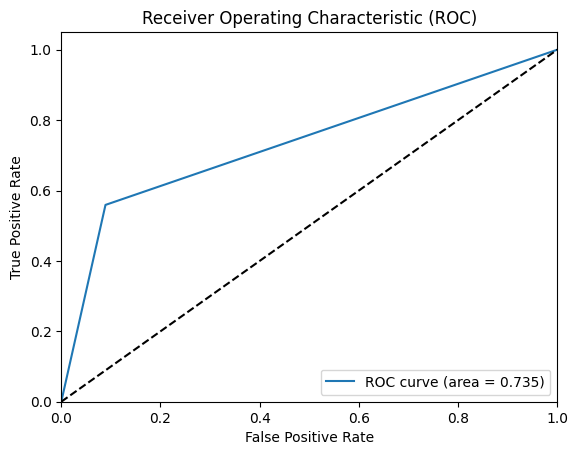

Accuracy: 0.875
F1: 0.47706422018348627
AUC: 0.7350033479065737
[[746  73]
 [ 41  52]]


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [23]:
# Import the accuracy metric
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print('Accuracy:', accuracy)
print('F1:', f1)
print('AUC:', roc_auc)

# confusion matrix
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))

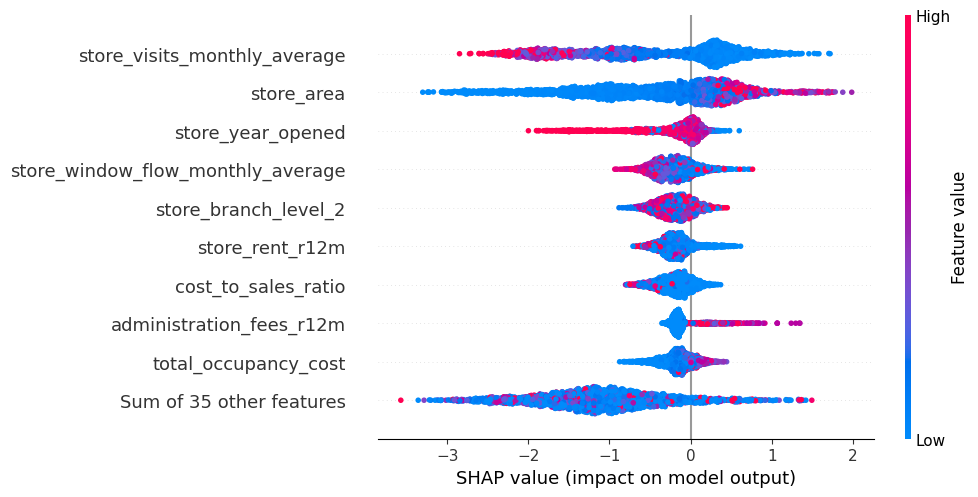

In [27]:
# find shap values
import shap
# For a tree-based model
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer(X_train)  # returns a shap.Explanation object

# If it's binary classification, shap_values.values might be shape [n_samples, 2, n_features]
# We pick the positive class (index = 1) via slicing
#


# shap_values_class1 = shap_values.values[:, :, 1]  # shape -> (2552, 10)
shap.plots.beeswarm(shap_values)

# # Now beeswarm for that class
# shap.plots.beeswarm(shap_values_class1)




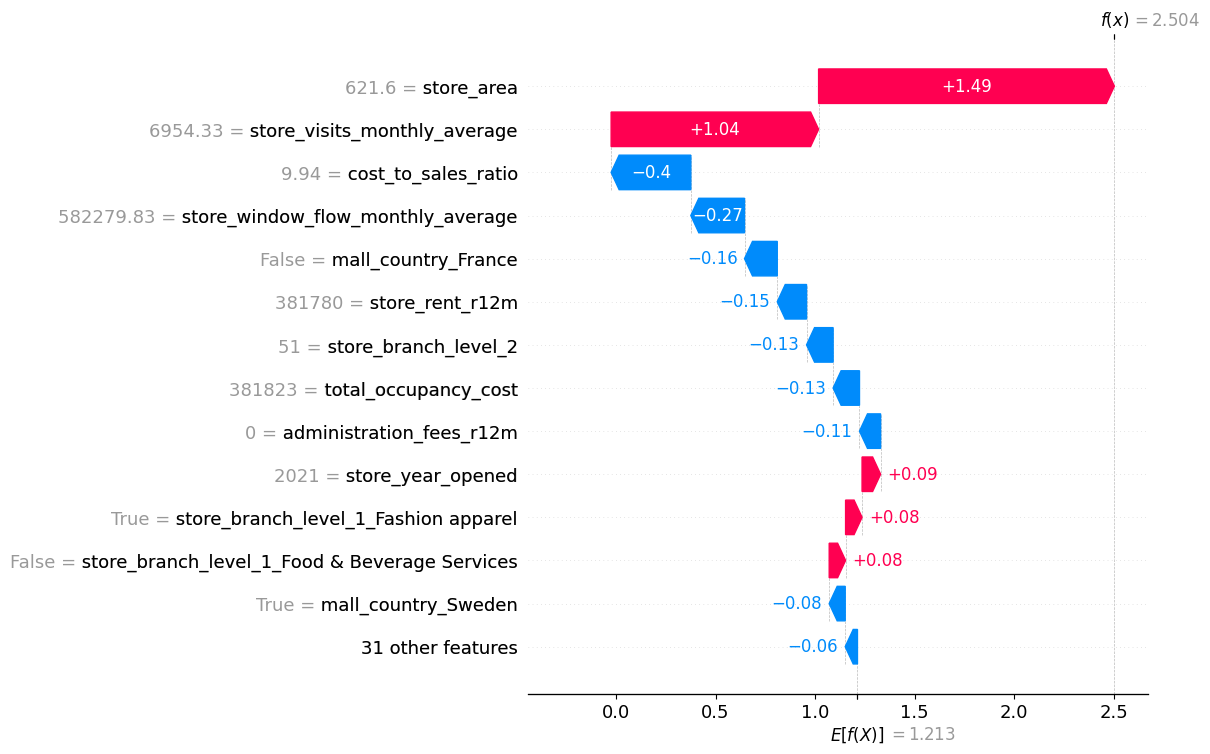

In [28]:
shap.plots.waterfall(shap_values[1], max_display=14)

In [26]:
store_ids = final['store_id']